# Band pass filter

One of the critical preprocessing steps in EEG signal analysis is **filtering**. EEG signals are often contaminated with noise and artifacts from various sources, including muscle activity, eye movements, and electrical interference. To isolate the brain's electrical activity of interest, filters are used to remove unwanted frequencies. A band pass filter is particularly useful in EEG signal processing, as it allows frequencies within a specific range to pass through while attenuating frequencies outside this range.

A band-pass filter combines the characteristics of both low-pass and high-pass filters. It allows frequencies within a certain range (the passband) to pass through while rejecting frequencies outside this range. The primary parameters of a band pass filter are:  
**Lower Cutoff Frequency**: The lower bound of the passband.  
**Upper Cutoff Frequency**: The upper bound of the passband.  
**Order of the Filter**: This determines the steepness of the filter's response and its attenuation outside the passband.

In the context of EEG, common frequency bands of interest include:  
**Delta** (0.5-4 Hz): Associated with deep sleep.   
**Theta** (4-8 Hz): Related to drowsiness and meditation.  
**Alpha** (8-13 Hz): Linked to relaxed, wakeful states.  
**Beta** (13-30 Hz): Associated with active thinking and focus.  
**Gamma** (30-100 Hz): Related to high-level cognitive functioning. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

In [3]:
data = pd.read_excel('datasets/dataset.xlsx')
data

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3
...,...,...,...,...,...,...,...,...
7115,23896.6,3893.1,37567.5,38276.6,11183.1,4515.5,31611.9,48532.8
7116,23850.2,3780.5,37514.3,38075.4,11119.7,4572.2,31551.9,48566.2
7117,23766.2,3644.2,37432.3,37477.1,11029.8,4755.0,31464.2,47165.5
7118,23768.4,3709.8,37443.6,37362.9,11048.4,4738.0,31481.5,46410.0


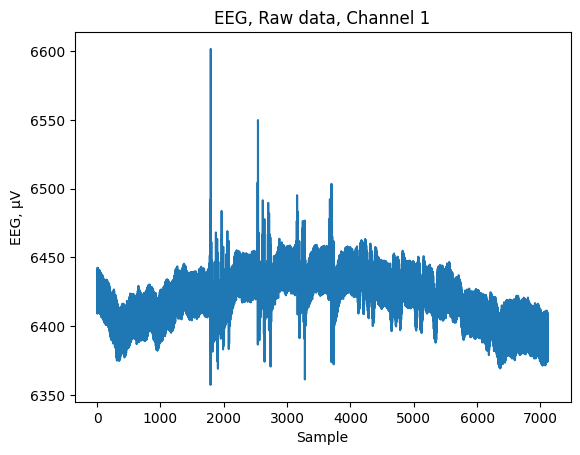

In [5]:
# select the data from the first channel
channel = 0
channel_data = data.iloc[:, channel]
# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts
channel_data = round(1000000*4.5*(channel_data/16777215),2)
# plot the EEG data
plt.plot(channel_data)
plt.title("EEG, Raw data, Channel " +str(channel + 1))
plt.ylabel('EEG, µV')  # Data from ADS1299
plt.xlabel('Sample')
plt.show()